In [1]:
from __future__ import division

from utils.prog import log_progress as lp
from IPython.display import display, HTML
import statsmodels.formula.api as smf
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from numpy import array as A
import scipy.stats as stats
import sklearn.cluster
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import scipy
import sys
import os
sys.stdout.write('.')
%matplotlib inline
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings("ignore")

CONDIR = os.environ.get("CONDIR")

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors
sns.set_palette(palettable.tableau.ColorBlind_10.hex_colors)
sns.set_style('white')

.

# Preparation

### Read in data

In [2]:
global_signal_regression = False
gsr = '' if global_signal_regression else '_gsr'
title = 'no GSR' if global_signal_regression else 'with GSR'
connectomes_all = np.load(os.path.join(CONDIR,'derivatives/connectomes.npy'))
connectomes_all_gsr = np.load(os.path.join(CONDIR,'derivatives/connectomes_gsr.npy'))
results_all = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results_all = results_all.drop('Unnamed: 0',axis=1)
statT_gsr = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_gsr.npy'))
statT = np.load(os.path.join(CONDIR,'derivatives/statT_mixed.npy'))
statP_gsr = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_gsr.npy'))
statP = np.load(os.path.join(CONDIR,'derivatives/statP_mixed.npy'))
statT_gsr_noqc = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_gsr_noqc.npy'))
statT_noqc = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_noqc.npy'))
statP_gsr_noqc = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_gsr_noqc.npy'))
statP_noqc = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_noqc.npy'))

In [3]:
def num_subs(results):
    dat = pd.DataFrame({"psychosis":[],"healthy control":[]})
    # number of subjects
    psyid = results.subject[results.patient==888]
    hcid = results.subject[results.patient==999]
    dat = dat.append(
        pd.Series({"psychosis":len(np.unique(psyid)),"healthy control":len(np.unique(hcid))},
                  name="total number of subjects")
    )
    dat = dat.append(
        pd.Series({"psychosis":len(psyid),"healthy control":len(hcid)},
                  name="total number of resting sessions")
    )
    out = dat.to_html()
    return HTML("<h4>Number of subjects/sessions </h4>%s"%out)

num_subs(results_all)

,healthy control,psychosis
total number of subjects,130,71
total number of resting sessions,513,278


In [4]:
# subset results where QA is passed
QAid = np.where(results_all.MOTION_pass==1)[0]
results = results_all.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]
results.reset_index()
connectomes = connectomes_all[:,:,QAid]
connectomes_gsr = connectomes_all_gsr[:,:,QAid]

num_subs(results)

,healthy control,psychosis
total number of subjects,113,52
total number of resting sessions,393,177


Extra QA: based on T1 quality (through MRIQC score)

In [5]:
# subset results where additional QA is passed
QAid_qc = np.where(np.logical_and(results_all.MRIQC_pass==1, results_all.MOTION_pass==1))[0]
results_qc = results_all.iloc[QAid_qc]
results_qc['patient_bin'] = ['True' if x==888 else 'False' for x in results_qc['patient']]
results_qc.reset_index()
connectomes_qc = connectomes_all[:,:,QAid_qc]
connectomes_gsr_qc = connectomes_all_gsr[:,:,QAid_qc]

num_subs(results_qc)

,healthy control,psychosis
total number of subjects,97,44
total number of resting sessions,340,154


In [6]:
#check if all connectomes have values
incon = [connectomes_gsr,connectomes_gsr_qc,connectomes,connectomes_qc]
inpat = [results.patient,results_qc.patient,results.patient,results_qc.patient]
insub = [results.subject,results_qc.subject,results.subject,results_qc.subject]
titles = ['with gsr','with gsr - additional QC','without gsr','without gsr - additional QC']

### Prepare labels and functions for connectome figures

In [7]:
def gordon_figure(correlation,limits,labelnames,title,ax=None):
    if ax == None:
        fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
    unique_labels = np.unique(labelnames)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for val,x in enumerate(labelnames)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    ax1 = ax.imshow(correlation,cmap = "PuOr_r",vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()

# Look at differences between psychosis and HC with classical statistics

## Parcelwise

In [8]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = range(333,353)
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27
labels = np.unique(labelnames)
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

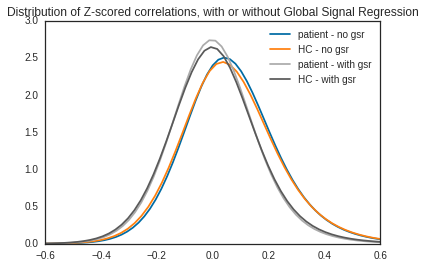

In [9]:
patient = [1 if x==888 else 0 for x in results.patient]
bins = np.arange(-1,1,0.5)
sns.distplot(connectomes[:,:,np.where(A(patient)==1)[0]].flatten(),hist=False,label='patient - no gsr',kde_kws={"bw":0.05})
sns.distplot(connectomes[:,:,np.where(A(patient)==0)[0]].flatten(),hist=False,label='HC - no gsr',kde_kws={"bw":0.05})
sns.distplot(connectomes_gsr[:,:,np.where(A(patient)==1)[0]].flatten(),hist=False,label="patient - with gsr",kde_kws={"bw":0.05})
sns.distplot(connectomes_gsr[:,:,np.where(A(patient)==0)[0]].flatten(),hist=False,label="HC - with gsr",kde_kws={"bw":0.05})
plt.xlim([-0.6,0.6])
plt.title("Distribution of Z-scored correlations, with or without Global Signal Regression")

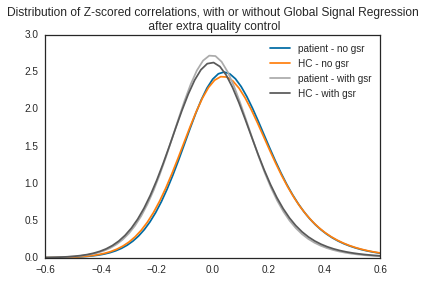

In [10]:
patient = [1 if x==888 else 0 for x in results_qc.patient]
bins = np.arange(-1,1,0.5)
sns.distplot(connectomes_qc[:,:,np.where(A(patient)==1)[0]].flatten(),hist=False,label='patient - no gsr',kde_kws={"bw":0.05})
sns.distplot(connectomes_qc[:,:,np.where(A(patient)==0)[0]].flatten(),hist=False,label='HC - no gsr',kde_kws={"bw":0.05})
sns.distplot(connectomes_gsr_qc[:,:,np.where(A(patient)==1)[0]].flatten(),hist=False,label="patient - with gsr",kde_kws={"bw":0.05})
sns.distplot(connectomes_gsr_qc[:,:,np.where(A(patient)==0)[0]].flatten(),hist=False,label="HC - with gsr",kde_kws={"bw":0.05})
plt.xlim([-0.6,0.6])
plt.title("Distribution of Z-scored correlations, with or without Global Signal Regression \n after extra quality control")


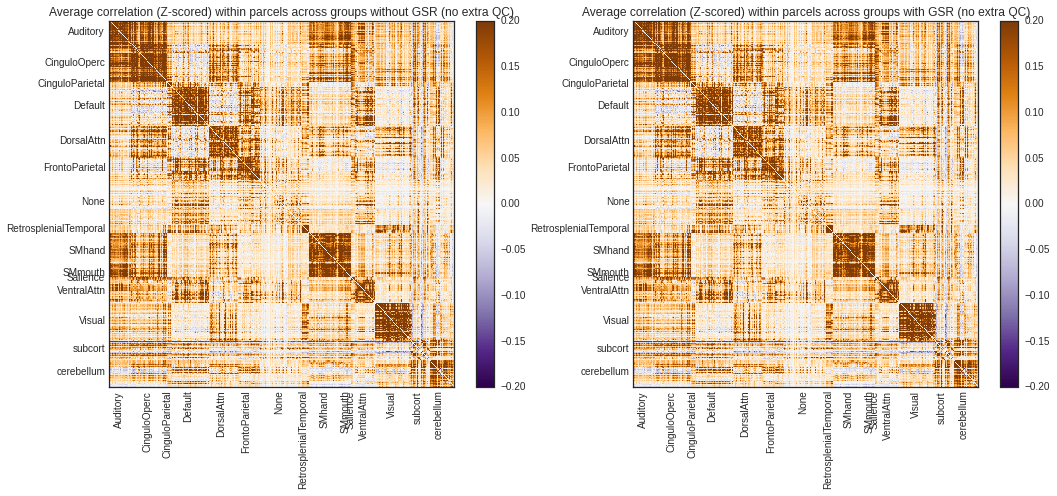

In [11]:
mncor = np.mean(connectomes,axis=2)
mncor = mncor[:,order]
mncor = mncor[order,:]

fig = plt.figure(figsize=(15, 7), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(121)
gordon_figure(mncor,
              limits=[-0.2,0.2],
              labelnames=labelnames,
              title="Average correlation (Z-scored) within parcels across groups without GSR (no extra QC)", ax=ax1)

mncor_gsr = np.mean(connectomes_gsr,axis=2)
mncor_gsr = mncor_gsr[:,order]
mncor_gsr = mncor_gsr[order,:]

ax2 = fig.add_subplot(122)
gordon_figure(mncor,
              limits=[-0.2,0.2],
              labelnames=labelnames,
              title="Average correlation (Z-scored) within parcels across groups with GSR (no extra QC)",ax=ax2)

### Now let's look at the difference between psychosis and healthy control (psychosis - HC)

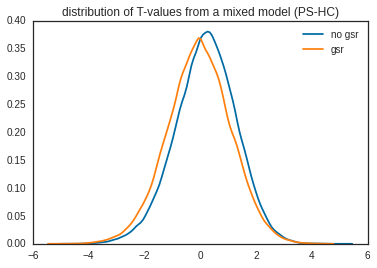

In [12]:
sns.distplot(statT.flatten(),hist=False,label='no gsr')
sns.distplot(statT_gsr.flatten(),hist=False,label="gsr")
plt.title("distribution of T-values from a mixed model (PS-HC)")

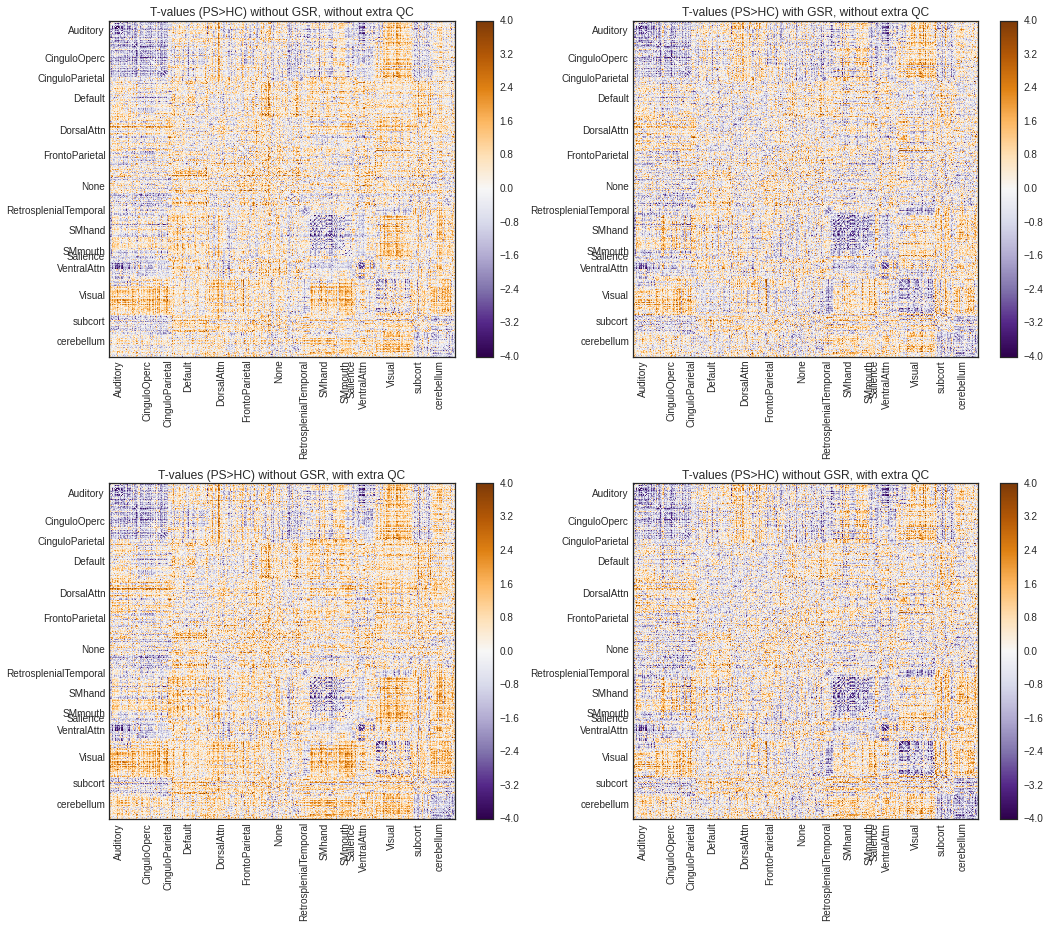

In [13]:
# plot T-stats
def plotT(matrix,title,ax=None):  
    cor = matrix[:,order]
    cor = cor[order,:]
    gordon_figure(cor,
                  limits=[-4,4],
                  labelnames=labelnames,
                  title=title, ax=ax)

fig = plt.figure(figsize=(15, 13), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)
plotT(statT_noqc,title="T-values (PS>HC) without GSR, without extra QC",ax=ax1)
ax2 = fig.add_subplot(222)
plotT(statT_gsr_noqc,title="T-values (PS>HC) with GSR, without extra QC",ax=ax2)
ax3 = fig.add_subplot(223)
plotT(statT,title="T-values (PS>HC) without GSR, with extra QC",ax=ax3)
ax4 = fig.add_subplot(224)
plotT(statT_gsr,title="T-values (PS>HC) without GSR, with extra QC",ax=ax4)

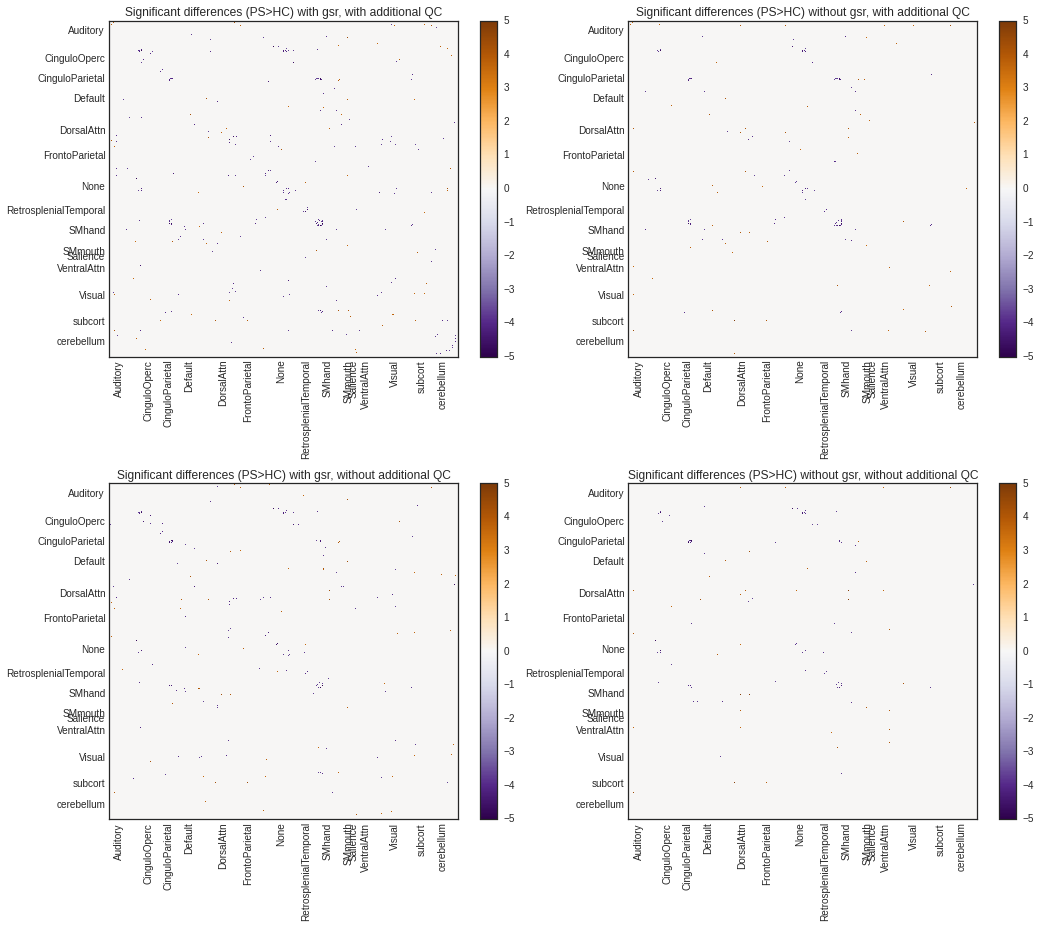

In [14]:
def BHthres(Pmat,Tmat,title,ax=None):
    upid = np.triu_indices(Pmat.shape[0])
    pvals = Pmat[upid]
    hlp = (np.argsort(pvals).argsort()+1)/len(pvals)*0.05
    sig = multipletests(pvals,method='fdr_bh')[0]
    sig = pvals<hlp
    bhpthres = np.max(pvals[sig])
    bhidx = np.where(Pmat<bhpthres)
    bhthres = np.zeros(Pmat.shape)
    bhthres[bhidx]=Tmat[bhidx]
    gordon_figure(bhthres,
                  limits=[-5,5],
                  labelnames=labelnames,
                  title=title,ax=ax)
    
fig = plt.figure(figsize=(15, 13), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)
BHthres(statP_gsr,statT_gsr,title="Significant differences (PS>HC) with gsr, with additional QC",ax=ax1)
ax2 = fig.add_subplot(222)
BHthres(statP,statT,title="Significant differences (PS>HC) without gsr, with additional QC",ax=ax2)
ax3 = fig.add_subplot(223)
BHthres(statP_gsr_noqc,statT_gsr_noqc,title="Significant differences (PS>HC) with gsr, without additional QC",ax=ax3)
ax4 = fig.add_subplot(224)
BHthres(statP_noqc,statT_noqc,title="Significant differences (PS>HC) without gsr, without additional QC",ax=ax4)